<a href="https://colab.research.google.com/github/agalvezm/ACE2_scRNAseq/blob/master/notebooks_countmatrices/GSE130117_GSM3732366.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GSE130117_GSM3732366

In [1]:
# Install SRA-toolkit 
!wget "http://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz"

! tar -xzf sratoolkit.current-centos_linux64.tar.gz

# Add to path
import os
os.environ['PATH'] += ":/content/sratoolkit.2.11.0-centos_linux64/bin"

# Configure
!vdb-config --interactive

# Import packages

import numpy as np


--2021-04-05 21:50:40--  http://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 165.112.9.229, 165.112.9.230, 2607:f220:41f:250::230, ...
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|165.112.9.229|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz [following]
--2021-04-05 21:50:40--  https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|165.112.9.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99139357 (95M) [application/x-gzip]
Saving to: ‘sratoolkit.current-centos_linux64.tar.gz’

sratoolkit.current- 100%[===================>]  94.55M  75.2MB/s    in 1.3s    

2021-04-05 21:50:42 (75.2 MB/s) 

In [2]:
# List of SRAs to download and transform. Copy paste from excel as string
SRAs = "SRR8949484"

SRAs = SRAs.split()

# SRA to delete, usually the index file, which get downloaded because we include technical reads. 
# It varies so check in the SRA website
SRA_to_delete = "3"


SRAs_to_keep = np.setdiff1d(["1", "2", "3"], [SRA_to_delete])


In [3]:
for sra in SRAs:
  """
  Downloads SRAs and transforms to compressed fastq file. Remove index reads and original SRA
  """
  # Download SRA
  !prefetch $sra --max-size 200000000

  # Convert to fastq. Biological reads are usually considered technicals in 10x so do not skip them.
  fastq_dump_cmd = "fastq-dump -F --gzip --readids --split-files " + sra + "/" + sra +".sra"
  !$fastq_dump_cmd

  # Remove files
  rm_cmd_1 = "rm " + sra + "/" + sra + ".sra"
  rm_cmd_2 = "rm " + sra + "_" + SRA_to_delete + ".fastq.gz" 
  !$rm_cmd_1
  !$rm_cmd_2


2021-04-05T21:51:50 prefetch.2.11.0: 1) Downloading 'SRR8949484'...
2021-04-05T21:51:50 prefetch.2.11.0:  Downloading via HTTPS...
2021-04-05T21:54:54 prefetch.2.11.0:  HTTPS download succeed
2021-04-05T21:54:54 prefetch.2.11.0:   verifying 'SRR8949484'...
2021-04-05T21:58:23 prefetch.2.11.0:  'SRR8949484' is valid
2021-04-05T21:58:23 prefetch.2.11.0: 1) 'SRR8949484' was downloaded successfully
2021-04-05T21:58:23 prefetch.2.11.0: 'SRR8949484' has 0 unresolved dependencies
Read 183591956 spots for SRR8949484/SRR8949484.sra
Written 183591956 spots for SRR8949484/SRR8949484.sra
rm: cannot remove 'SRR8949484_3.fastq.gz': No such file or directory


In [4]:
# Define fastq list to feed kb

fastqs = []
for sra in SRAs:
  for read in SRAs_to_keep:
    fastqs.append(sra + "_" + read + ".fastq.gz")

## Metadata

In [5]:
# define the values for the analysis

# accession id for the data
id = "GSE130117"

samp_id = ["GSM3732366"]

no_samples = 1

fastqs_per_sample = [8] 

sample_id = samp_id

database_id = [id] * no_samples

tissue = ["blood"] * no_samples

cell_type = ["PBMCs"] * no_samples

condition = ["None"] * no_samples

species = ["human"] * no_samples

technology = ["10xv2"] * no_samples

paper = ["Muus et al 2020"] * no_samples

figure = ["Fig 1 a,b  ED Fig 1 a,b,c,d  ED Fig 2 a,b,c,d,e"] * no_samples


# Set string variables for kb functions

species_kb = species[0]

technology_kb = technology[0]

# Imports and installs

In [6]:
# install and import necessary software

# Install kb and scanpy
!pip -q install kb-python 
!pip -q install scanpy

import re
import os

# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

     |████████████████████████████████| 59.1MB 97kB/s 
     |████████████████████████████████| 13.2MB 35.9MB/s 
     |████████████████████████████████| 122kB 38.9MB/s 
     |████████████████████████████████| 51kB 3.7MB/s 
     |████████████████████████████████| 10.3MB 32.4MB/s 
     |████████████████████████████████| 112kB 54.3MB/s 
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 1.2MB 43.6MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 71kB 5.1MB/s 


# Downloads: index

In [7]:
# Download the corresponding Kallisto index to fastq folder
!kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2021-04-06 04:51:25,123]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
100% 2.23G/2.23G [01:45<00:00, 22.6MB/s]
[2021-04-06 04:53:12,046]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


# Process fastq files (modify kb command according to fastqs list)


In [8]:
fastqs

['SRR8949484_1.fastq.gz', 'SRR8949484_2.fastq.gz']

In [9]:
# Specify the sample number 


if no_samples == 1:

  # Write the kb count command as a string with all fastqs of the list as an input
  cmd = "kb count --h5ad -i index.idx -g t2g.txt -x " + technology_kb + " -o output" + sample_id[0] + " "\
  + "--filter bustools -t 2 --overwrite " + "'" +  "' '".join(fastqs) + "'"
  
  # Execute it
  !$cmd

# If more than one sample, iterate through fastqs accordingly
else:

  # Initializa counter for fastq files
  j = 0

  # Loop over samples for analysis
  for i in range(no_samples):

    fastqs_to_analyze = fastqs[j:j + fastqs_per_sample[i]]
    # Write the kb count command as a string
    cmd = "kb count --h5ad -i index.idx -g t2g.txt -x " + technology_kb + " -o output" + sample_id[i] + " \
    --filter bustools -t 2 --overwrite " + "'" +  "' '".join(fastqs_to_analyze) + "'"

    # Execute it
    !$cmd

    # Update j to move to the next set of fastq
    j = j + fastqs_per_sample[i]







[2021-04-06 04:53:53,735]    INFO Using index index.idx to generate BUS file to outputGSM3732366 from
[2021-04-06 04:53:53,736]    INFO         SRR8949484_1.fastq.gz
[2021-04-06 04:53:53,736]    INFO         SRR8949484_2.fastq.gz
[2021-04-06 05:58:07,404]    INFO Sorting BUS file outputGSM3732366/output.bus to outputGSM3732366/tmp/output.s.bus
[2021-04-06 05:58:53,145]    INFO Whitelist not provided
[2021-04-06 05:58:53,146]    INFO Copying pre-packaged 10XV2 whitelist to outputGSM3732366
[2021-04-06 05:58:53,275]    INFO Inspecting BUS file outputGSM3732366/tmp/output.s.bus
[2021-04-06 05:59:08,840]    INFO Correcting BUS records in outputGSM3732366/tmp/output.s.bus to outputGSM3732366/tmp/output.s.c.bus with whitelist outputGSM3732366/10xv2_whitelist.txt
[2021-04-06 05:59:20,052]    INFO Sorting BUS file outputGSM3732366/tmp/output.s.c.bus to outputGSM3732366/output.unfiltered.bus
[2021-04-06 05:59:47,702]    INFO Generating count matrix outputGSM3732366/counts_unfiltered/cells_x_gen

# Load unfiltered matrix and assign filters to each matrix individually

## Load the unfiltered matrix (check dimensions)

In [10]:
# Define dict to store data
results = {}


In [11]:
# load the unfiltered matrix
for i in range(no_samples):
  results[sample_id[i]] = anndata.read_h5ad("output" + sample_id[i] + "/counts_unfiltered/adata.h5ad")
  results[sample_id[i]].var["gene_id"] = results[sample_id[i]].var.index.values

  t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
  t2g.index = t2g.gene_id
  t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

  results[sample_id[i]].var["gene_name"] = results[sample_id[i]].var.gene_id.map(t2g["gene_name"])
  results[sample_id[i]].var.index = results[sample_id[i]].var["gene_name"]
  print("The unfiltered matrix " + sample_id[i] + " contains {} cells by {} genes".format(len(results[sample_id[i]].obs), len(results[sample_id[i]].var)))

  results[sample_id[i]].obs["cell_counts"] = results[sample_id[i]].X.sum(axis=1)
  results[sample_id[i]].var["gene_counts"] = nd(results[sample_id[i]].X.sum(axis=0))

  results[sample_id[i]].obs["n_genes"] = nd((results[sample_id[i]].X>0).sum(axis=1))
  results[sample_id[i]].var["n_cells"] = nd((results[sample_id[i]].X>0).sum(axis=0))

  mito_genes = results[sample_id[i]].var_names.str.startswith("MT-" or "mt-") 
  results[sample_id[i]].obs["percent_mito"] = results[sample_id[i]][:,mito_genes].X.sum(axis=1)/results[sample_id[i]].X.sum(axis=1)*100

  # Changing the name of the index is necessary to write the file (it won't work with duplicated names)
  results[sample_id[i]].var.index.name = "index"



The unfiltered matrix GSM3732366 contains 215171 cells by 60623 genes


## Assign filters for each matrix individually

In [12]:
# Modify this manually to change sample after having assigned the "expected_num_cells" and "mito_criteria" parameters
samp_n = 0


# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30

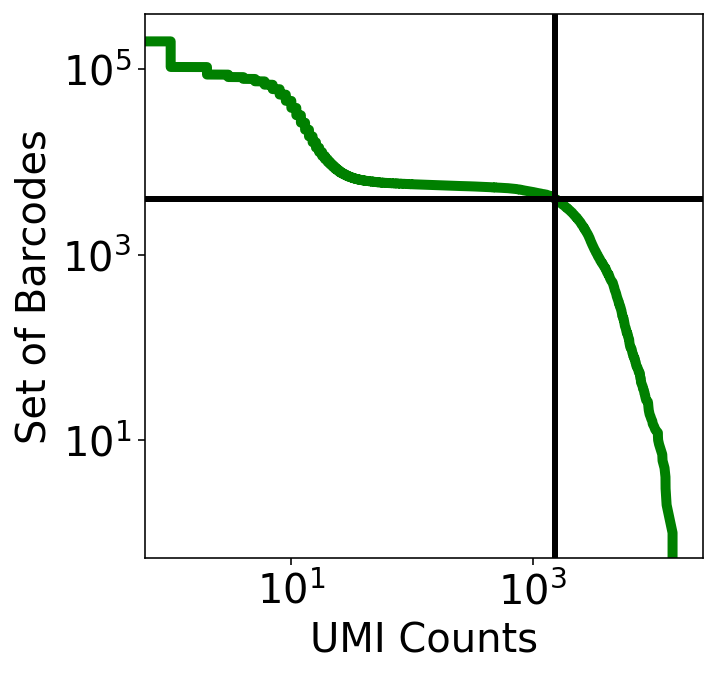

Cells were filtered down to 4000 with at least 1541.0 UMIs


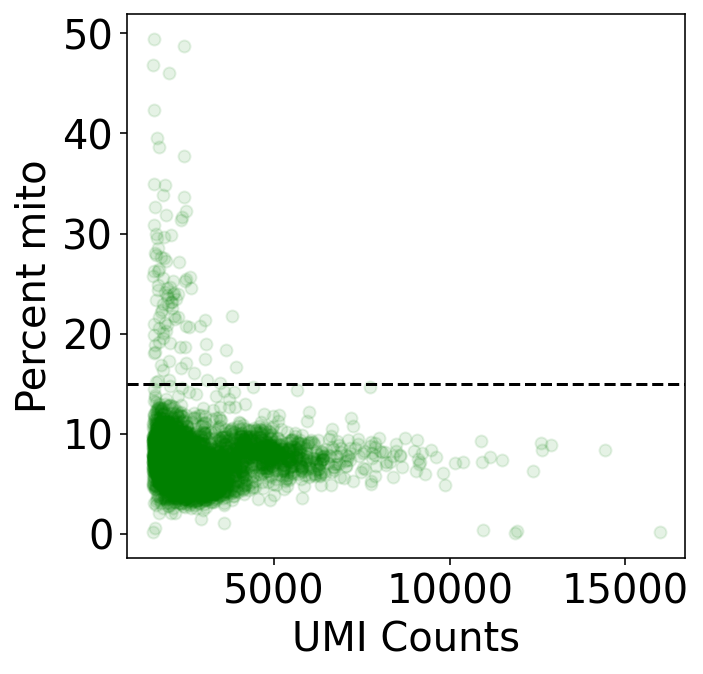

We select 15 % as the mitochondrial content threshold


In [17]:

expected_num_cells = 4000#@param {type:"integer"}
knee = np.sort(nd(results[sample_id[samp_n]].X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

cell_threshold = knee[expected_num_cells]

results["cell_threshold" + sample_id[samp_n]] = knee[expected_num_cells]

print ("Cells were filtered down to " + str(expected_num_cells) + " with at least " + str(cell_threshold) + " UMIs")


mito_criteria = 15#@param {type:"integer"}
results["mito_criteria" + sample_id[samp_n]] = mito_criteria

fig, ax = plt.subplots(figsize=(5,5))


x = nd(results[sample_id[samp_n]].obs["cell_counts"][results[sample_id[samp_n]].obs["cell_counts"] > cell_threshold])
y = nd(results[sample_id[samp_n]].obs["percent_mito"][results[sample_id[samp_n]].obs["cell_counts"] > cell_threshold])

ax.scatter(x, y, color="green", alpha=0.1)

ax.axhline(y=mito_criteria, linestyle="--", color="k")


ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")


plt.show()

print("We select " + str(mito_criteria) + " % as the mitochondrial content threshold")

# Filter matrix

In [18]:
for i in range(no_samples):
  results[sample_id[i]].obs["pass_count_filter"] = results[sample_id[i]].obs["cell_counts"] > results["cell_threshold" + sample_id[i]]
  results[sample_id[i]].obs["pass_mito_filter"] = results[sample_id[i]].obs.percent_mito < results["mito_criteria" + sample_id[i]]
  results[sample_id[i]].var["pass_gene_filter"] = results[sample_id[i]].var["n_cells"] > gene_threshold

  cell_mask = np.logical_and(results[sample_id[i]].obs["pass_count_filter"].values, results[sample_id[i]].obs["pass_mito_filter"].values)
  gene_mask = results[sample_id[i]].var["pass_gene_filter"].values

  print("Current Shape: {:,} cells x {:,} genes".format(results[sample_id[i]].shape[0], results[sample_id[i]].shape[1]))
  print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))
  results["data_" + sample_id[i]] = results[sample_id[i]][cell_mask, gene_mask]

Current Shape: 215,171 cells x 60,623 genes
    New shape: 3,903 cells x 25,179 genes


# Anotate and write the Anndata object

In [19]:
for i in range(no_samples):


  results["data_" + sample_id[i]].uns["database_id"] = database_id[samp_n]

  results["data_" + sample_id[i]].uns["tissue"] = tissue[samp_n]

  results["data_" + sample_id[i]].uns["cell_type"] = cell_type[samp_n]

  results["data_" + sample_id[i]].uns["sample_id"] = sample_id[samp_n]

  results["data_" + sample_id[i]].uns["condition"] = condition[samp_n]

  results["data_" + sample_id[i]].uns["species"] = species[samp_n]

  results["data_" + sample_id[i]].uns["technology"] = technology[samp_n]

  results["data_" + sample_id[i]].uns["paper"] = paper[samp_n]

  results["data_" + sample_id[i]].uns["figure"] = figure[samp_n]


%cd /content

for i in range(no_samples):

  results["data_" + sample_id[i]].write("result" + sample_id[i])

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/content


... storing 'gene_name' as categorical
